In [1]:
# Please ensure the dir structure matches before we run this code.
!ls

8280_throughput.csv
9282_throughput.csv
V100_10_instance
V100_11_instance
V100_12_instance
V100_13_instance
V100_14_instance
V100_15_instance
V100_16_instance
V100_17_instance
V100_18_instance
V100_19_instance
V100_1_instance
V100_20_instance
V100_2_instance
V100_3_instance
V100_4_instance
V100_5_instance
V100_6_instance
V100_7_instance
V100_8_instance
V100_9_instance
post_process_throughput_multi_plots.ipynb
throughput.csv
v100_throughput.csv


### Get all throughput data with 99% latency from the JSON files

In [2]:
import json
import pandas as pd

In [3]:
def process_one_file(filename):
    """
    Get all throughput numbers from one Json file.
    Args:
        filename: path to the Json file
    Returns:
        A list of list of strings of model_name,
        instance_count, system_throughput, 99th_latency,
        batch_size
    """
    
    instance_count = filename.split('_')[1] # GPU is 1, CPU is 2
    output = []
    with open(filename) as f: 
        data= json.load(f)

        all_results = data['Result']['Deep-Learning']\
                               ['Workloads']

        for item in all_results:
            model_results = item['results']
            for entry in model_results:
                one_line= [item['workloadName']]
                one_line.append(str(instance_count))
                one_line.append(entry['system_throughput'])
                one_line.append(float(entry['additional info'][0]\
                                ['99_percentile_time'])/1000)
                # latency bug: microsec -> divide by 1000
                one_line.append(entry['label'].split(' ')[1])
                output.append(one_line)
    return output
        

In [4]:
import os

def get_jsons(root_dir):
    # get a list of Json filenames in the current folder 
    # recursively
    
    output = []
    extensions = ['.json']
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            if ext in extensions:
                output.append(os.path.join(subdir, file))
    return output

In [5]:
# populating the output CSV by getting results from all
# json files

content = [['model_name','instance_count', 'system_throughput', \
            '99th_latency', 'batch_size']]

all_files = get_jsons('.')

for filename in all_files:
    result = process_one_file(filename)
    content += result

In [6]:
# save the output CSV with complete 99% throughput data
import csv
output_filename = 'throughput.csv'

with open(output_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(content)

### Plot max throughput VS latency constraints 

In [7]:
# Exam all latency numbers from the saved CSV
df = pd.read_csv(output_filename, delimiter = ',')
df.head()

,model_name,instance_count,system_throughput,99th_latency,batch_size
0,ResNet-50,5,1957.969445,2.916,1
1,ResNet-50,5,2539.027390,4.430,2
2,ResNet-50,5,3366.394129,6.707,4
3,ResNet-50,5,5038.193918,8.537,8
4,ResNet-50,5,6035.655029,14.676,16


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_throughput(model_name, lower_latency, higher_latency):
    x_vals = range(lower_latency, higher_latency+1)
    y_vals = list()
    for x in x_vals:
        sub_results = df.loc[(df['model_name'] == model_name) \
               & (df['99th_latency'] < x)]
        y = sub_results['system_throughput'].max()
        y_vals.append(y)
    plt.title(model_name +\
              ': maximum throughput with 99% latency bound')
    plt.xlabel('latency bound in milli sec')
    plt.ylabel('images per sec')
    plt.plot(x_vals, y_vals)
    
    return 

In [9]:
#Get all model names
model_names = (df.model_name.unique())
count = len(model_names)
lower_latency = 0
higher_latency = 50

print(model_names)

['ResNet-50' 'SSD-MobileNet-v1']


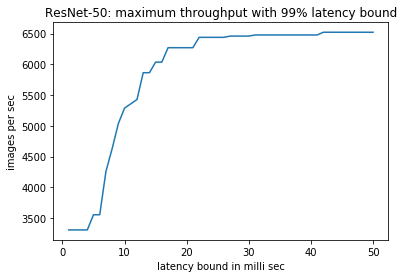

In [10]:
plot_throughput('ResNet-50', lower_latency, higher_latency)

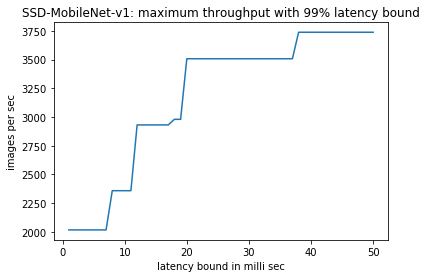

In [11]:
plot_throughput('SSD-MobileNet-v1', lower_latency, higher_latency)

In [12]:
### plot multiplt HW together


In [14]:
# Exam all latency numbers from the saved CSV

cpu_name = '9282'

cpu_df = pd.read_csv(cpu_name + '_throughput.csv', delimiter = ',')
cpu_df.head()


,model_name,instance_count,system_throughput,99th_latency,batch_size
0,ResNet-50,34,4225.411,23.898056,1
1,ResNet-50,34,4063.997,81.958531,2
2,ResNet-50,34,4281.662,116.881646,4
3,ResNet-50,34,4539.925,211.653048,8
4,ResNet-50,34,4628.971,322.726315,16


In [15]:
gpu_df = pd.read_csv('V100_throughput.csv', delimiter = ',')
gpu_df.head()

,model_name,instance_count,system_throughput,99th_latency,batch_size,Unnamed: 5,Unnamed: 6
0,ResNet-50,1,908.360784,1.226323,1,NaN,0.001226
1,SSD-MobileNet-v1,1,510.427856,2.114723,1,NaN,0.002115
2,ResNet-50,1,1276.128057,1.718094,2,NaN,0.001718
3,SSD-MobileNet-v1,1,961.440186,2.293971,2,NaN,0.002294
4,ResNet-50,1,1501.868270,3.022011,4,NaN,0.003022


In [16]:
def get_y_vals(df, model_name, x_vals):
    y_vals = list()
    for x in x_vals:
        sub_results = df.loc[(df['model_name'] == model_name) \
               & (df['99th_latency'] < x)]
        y = sub_results['system_throughput'].max()
        y_vals.append(y)
    return y_vals
    


def plot_throughput_two_hw(model_name, cpu_df, gpu_df, \
                           lower_latency, higher_latency,
                          vert_latency):
    x_vals = range(lower_latency, higher_latency+1)
    cpu_y_vals = get_y_vals(cpu_df, model_name, x_vals)
    gpu_y_vals = get_y_vals(gpu_df, model_name, x_vals)
    
    plt.title(model_name +\
              ': maximum throughput with 99% latency bound')
    plt.xlabel('latency bound in milli sec')
    plt.ylabel('images per sec')
    plt.plot(x_vals, cpu_y_vals, 'blue', label = cpu_name)
    plt.plot(x_vals, gpu_y_vals, 'green', label = 'V100')
    plt.axvline(x=vert_latency)
    plt.legend(loc='middle right')

    
    return 



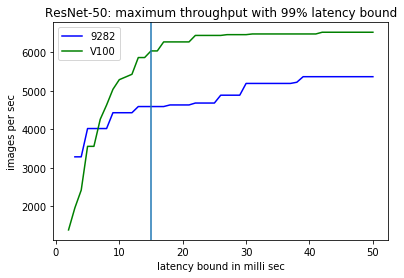

In [17]:
plot_throughput_two_hw('ResNet-50',cpu_df, gpu_df, lower_latency, higher_latency, 15)

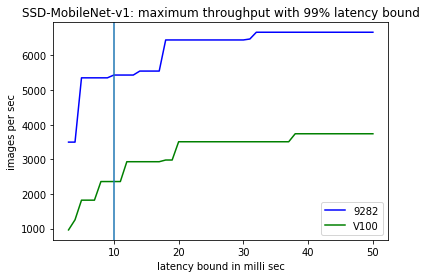

In [18]:
plot_throughput_two_hw('SSD-MobileNet-v1',cpu_df, gpu_df, lower_latency, higher_latency, 10)